In [1]:
# Get everything setup for dedicated module loading

%load_ext autoreload
%autoreload 2
from renault.plot import *
from renault.get_data import get_pji_with_misssing_fluids_measure
from renault.knn_preprocessing import preprocess_data, datetime_reshaping


In [21]:
import numpy as np 
import pandas as pd
import datetime 

import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors, LocalOutlierFactor
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.svm import OneClassSVM

from sklearn.cluster import KMeans

import plotly.graph_objects as go
import plotly.express as px

# Data Analysis Check

In [9]:
df = pd.read_csv('../data/train_df_LHA.csv',index_col='Unnamed: 0' )
filling = ['ActVolume', 'ActMass']
STEPS = ['StepLoading', 'StepEndLoading']

In [11]:
most_common_df = datetime_reshaping(df)
most_common_df

,siteCode,objectUAI,machine,fluid,measurement,step,sourceTimestamp,pji,dataValue,body_type,driving_side,gearbox_type,hybrid_level,engine_type,time,delta
310695,FRLHA,A000003FY5,FillingStation_1,FRFluid,ActLoadingPressure,StepLoading,2021-01-25 11:02:29.625000+00:00,810451,68.0,F82,DG,BVM6,NOT_HYBRID,M9R,2021-01-25 11:02:29.625000+00:00,0.000
313513,FRLHA,A000003FY5,FillingStation_1,FRFluid,ActLoadingPressure,StepLoading,2021-01-25 11:02:41.828000+00:00,810451,345.0,F82,DG,BVM6,NOT_HYBRID,M9R,2021-01-25 11:02:41.828000+00:00,12.203
305805,FRLHA,A000003FY5,FillingStation_1,FRFluid,ActLoadingPressure,StepLoading,2021-01-25 11:02:46.437000+00:00,810451,474.0,F82,DG,BVM6,NOT_HYBRID,M9R,2021-01-25 11:02:46.437000+00:00,4.609
310693,FRLHA,A000003FY5,FillingStation_1,FRFluid,ActLoadingPressure,StepLoading,2021-01-25 11:02:48.937000+00:00,810451,474.0,F82,DG,BVM6,NOT_HYBRID,M9R,2021-01-25 11:02:48.937000+00:00,2.500
315053,FRLHA,A000003FY5,FillingStation_1,FRFluid,ActLoadingPressure,StepLoading,2021-01-25 11:02:52.937000+00:00,810451,481.0,F82,DG,BVM6,NOT_HYBRID,M9R,2021-01-25 11:02:52.937000+00:00,4.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155787,FRLHA,A000003FY5,FillingStation_1,RMFluid,ActVolume,StepLoading,2021-01-27 20:01:37.640000+00:00,740170,1392.0,F82,DG,BVM6,NOT_HYBRID,M9R,2021-01-27 20:01:37.640000+00:00,0.781
162288,FRLHA,A000003FY5,FillingStation_1,RMFluid,ActVolume,StepLoading,2021-01-27 20:01:38.859000+00:00,740170,1393.0,F82,DG,BVM6,NOT_HYBRID,M9R,2021-01-27 20:01:38.859000+00:00,1.219
169504,FRLHA,A000003FY5,FillingStation_1,RMFluid,ActVolume,StepLoading,2021-01-27 20:01:40.359000+00:00,740170,1394.0,F82,DG,BVM6,NOT_HYBRID,M9R,2021-01-27 20:01:40.359000+00:00,1.500
152151,FRLHA,A000003FY5,FillingStation_1,RMFluid,ActVolume,StepLoading,2021-01-27 20:01:42.531000+00:00,740170,1395.0,F82,DG,BVM6,NOT_HYBRID,M9R,2021-01-27 20:01:42.531000+00:00,2.172


Number of steps for each type of measurements

In [24]:
df[df.measurement.isin(filling)].groupby(['fluid','pji', 'step', 'measurement'], as_index=False) \
    .agg({'dataValue': 'describe'}) \
    .groupby(['fluid',  'measurement','step']) \
    .count()

/Users/alix/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/pandas/core/generic.py:4147: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


pji dataValue                             
                                           count mean std min 25% 50% 75% max
fluid   measurement step                                                     
FRFluid ActVolume   StepEndLoading  42        42   42  25  42  42  42  42  42
                    StepLoading     58        58   58  58  58  58  58  58  58
RMFluid ActVolume   StepEndLoading   5         5    5   1   5   5   5   5   5
                    StepLoading     58        58   58  58  58  58  58  58  58

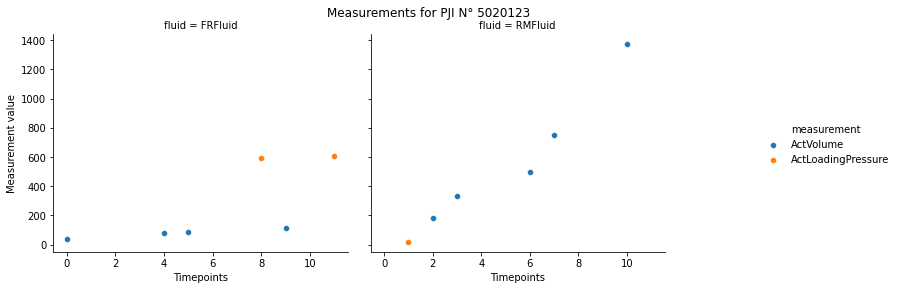

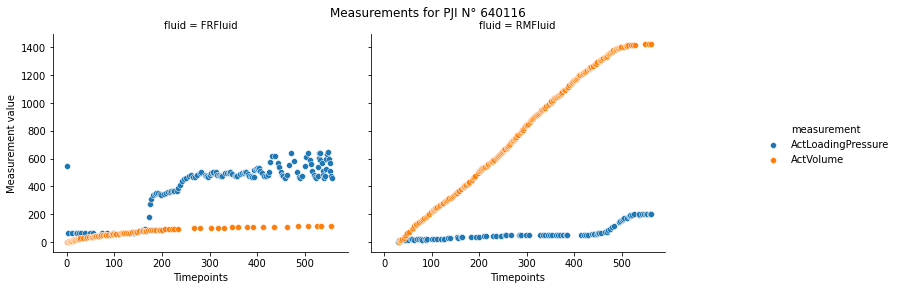

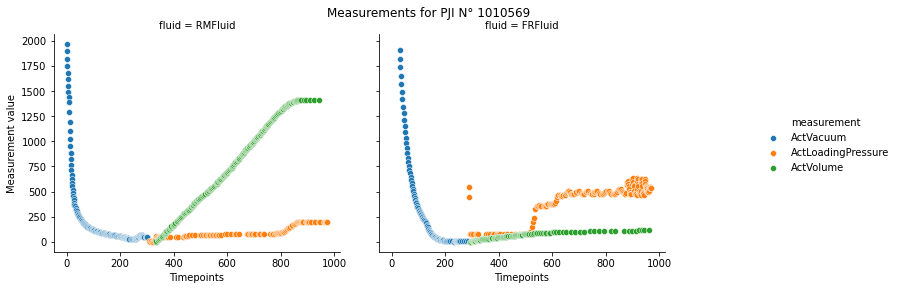

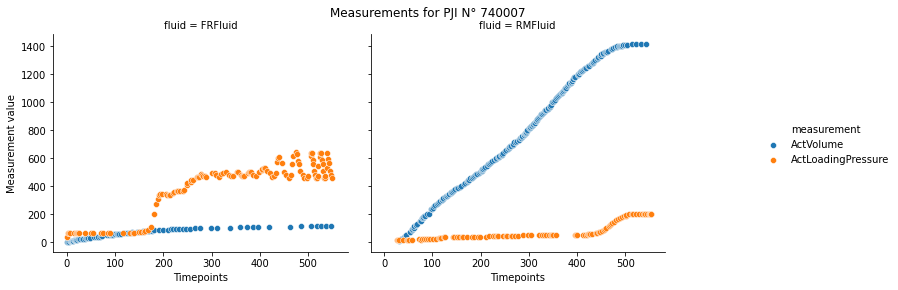

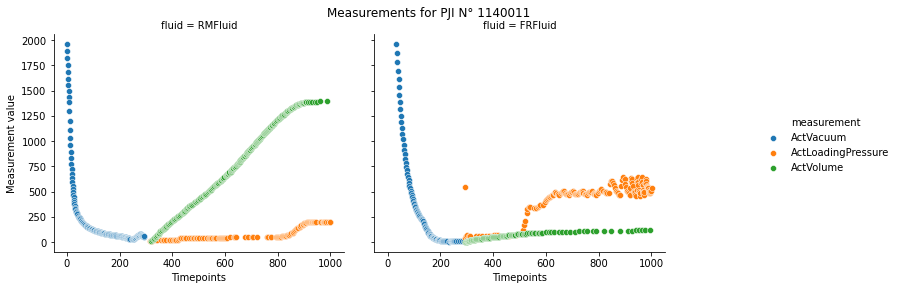

In [26]:
df.sourceTimestamp = pd.to_datetime(df.sourceTimestamp)
df.sort_values('sourceTimestamp', inplace=True)
for num in np.random.choice(df.pji.unique(), 5):
    plot_all_fluid(df,num)

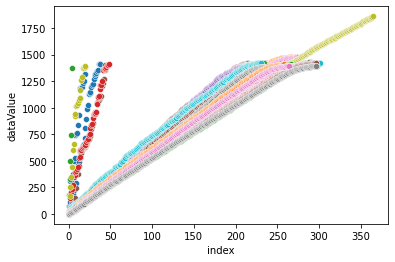

In [28]:
for num in df.pji.unique():
    plot_selective_fluid(df,num, 'RMFluid', 'ActVolume')

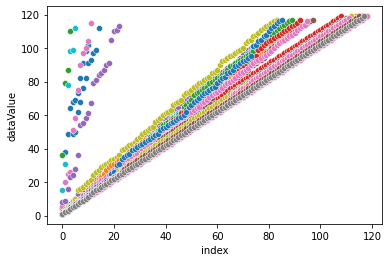

In [29]:
for num in df.pji.unique():
    plot_selective_fluid(df,num, 'FRFluid', 'ActVolume')

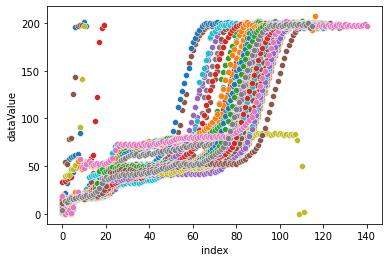

In [30]:
for num in df.pji.unique():
    plot_selective_fluid(df,num, 'RMFluid', 'ActLoadingPressure')

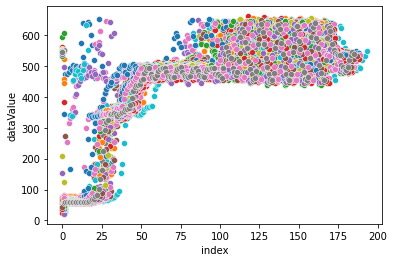

In [31]:
for num in df.pji.unique():
    plot_selective_fluid(df,num, 'FRFluid', 'ActLoadingPressure')

In [37]:
df[(df.dataValue > 1500) & (df.measurement == 'ActVolume') ]['pji'].unique()

array([4620256])

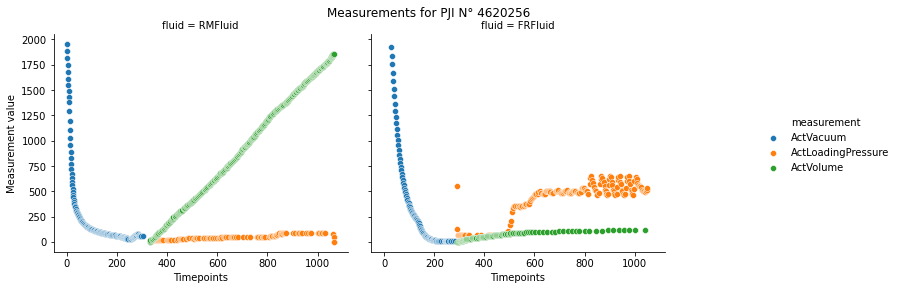

In [38]:
plot_all_fluid(df, 4620256)

In [28]:
most_common_df.time.dt.month.unique()

array([1])

# model fit

In [39]:
bad_pji = get_pji_with_misssing_fluids_measure(most_common_df, n_fluids=2,n_measure=2)
bad_pji

[1240068, 320261]

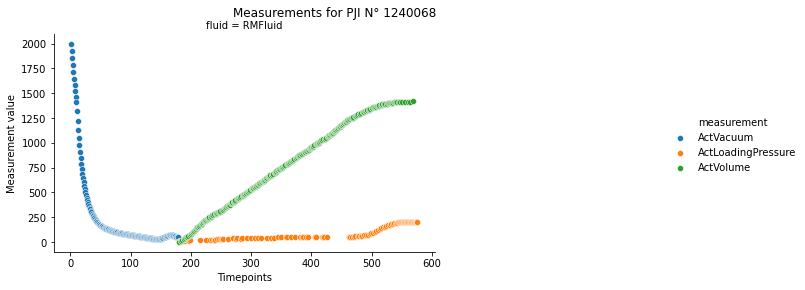

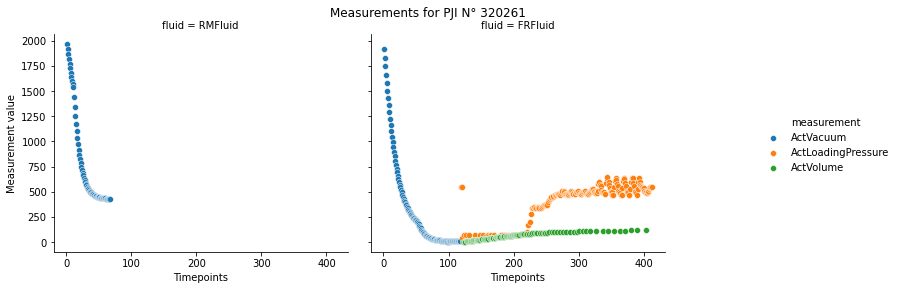

In [30]:
for pji in bad_pji:
    plot_all_fluid(df, pji)

In [14]:
# Global organisation of the data
# remove pji without 3 fluids and 3 measurements
#bad_pji = get_pji_with_misssing_fluids_measure(most_common_df)
most_common_df = most_common_df[most_common_df['measurement'] != 'ActVacuum']
most_common_df = most_common_df[~most_common_df.pji.isin(bad_pji)]

# Observations are PJI
# columns are the differents features regrouped by fluids and measurements
# important features
# Average dataValue in tail(10)
tail_analysis = most_common_df.groupby(['pji', 'fluid', 'measurement']).tail(4)
tail_analysis = tail_analysis.groupby(['pji', 'fluid', 'measurement'])[['dataValue']].mean()

#tail_analysis

end_distrib_analysis = most_common_df\
.groupby(['pji', 'fluid', 'measurement'])['dataValue']\
.describe(percentiles=[0.1, 0.2, 0.8, 0.9]
)

end_distrib_analysis = end_distrib_analysis.drop(['count', 'std'], axis=1)

# Number of points in each group + average time delta
timing = most_common_df.groupby(['pji', 'fluid', 'measurement']).agg({'delta':['count', 'mean', 'max']})
#timing

# Slope values (min max or q10, q90)
tdelta_analysis = most_common_df.copy()
tdelta_analysis = tdelta_analysis.sort_values(['fluid', 'measurement', 'time'])
slope = tdelta_analysis.groupby(['pji', 'fluid', 'measurement'])['dataValue'].diff()
tdelta_analysis = most_common_df.copy()
tdelta_analysis['slope'] = slope
tdelta_analysis = tdelta_analysis.groupby(['pji', 'fluid', 'measurement']).agg({'slope':["mean", "max"]})

#tdelta_analysis

global_merged = pd.concat([tail_analysis, timing, tdelta_analysis, end_distrib_analysis],
                          axis=1, join='inner')
column_list = global_merged.columns
final_df = global_merged.pivot_table(values=column_list, 
                   index = ['pji'],
                   columns=['fluid', 'measurement'], sort=False )

final_df

dataValue            ...                max          
fluid                  FRFluid            ...            RMFluid          
measurement ActLoadingPressure ActVolume  ... ActLoadingPressure ActVolume
pji                                       ...                             
130567                  528.50    116.50  ...              200.0    1422.0
220378                  537.25    117.50  ...              200.0    1427.0
310143                  511.50    116.50  ...              202.0    1390.0
310167                  520.50    117.50  ...              200.0    1418.0
310586                  533.00    116.50  ...              200.0    1421.0
320115                  540.75    116.50  ...              201.0    1421.0
320294                  530.00    116.50  ...              200.0    1422.0
330063                  539.00    116.50  ...              200.0    1399.0
330549                  539.25    116.50  ...              200.0    1419.0
340237                  538.50    116.50  ...              200.0    1420.0
340316                  538.00    117.50  ...              200.0    1426.0
350038                  537.50    116.50  ...              202.0    1476.0
350041                  525.00    116.50  ...              201.0    1477.0
350156                  539.50    117.50  ...              201.0    1423.0
610625                  530.00    109.75  ...              198.0    1415.0
620372                  489.75    115.50  ...              200.0    1398.0
620543                  544.75     96.75  ...              197.0    1389.0
630207                  473.75    115.50  ...              200.0    1400.0
640116                  503.00    114.75  ...              199.0    1425.0
640364                  528.50    116.50  ...              200.0    1398.0
640367                  525.25    114.50  ...              199.0    1419.0
650149                  480.00    113.75  ...              199.0    1399.0
650183                  502.50    117.50  ...              201.0    1410.0
730150                  519.75    112.00  ...              200.0    1418.0
740007                  501.75    115.50  ...              200.0    1419.0
740155                  502.00    117.50  ...              200.0    1419.0
740156                  526.75    117.50  ...              200.0    1419.0
740170                  534.50    117.50  ...              200.0    1396.0
810189                  538.50    115.50  ...              200.0    1401.0
810451                  536.50     93.25  ...              201.0    1388.0
810452                  527.75    117.50  ...              202.0    1389.0
810589                  477.50    114.50  ...              199.0    1417.0
810778                  513.25    114.00  ...              201.0    1399.0
910105                  520.25    117.50  ...              200.0    1420.0
911115                  518.25    115.25  ...              200.0    1421.0
940005                  537.25    116.50  ...              200.0    1419.0
1010403                 546.25    100.25  ...              196.0    1413.0
1010501                 527.50    117.50  ...              199.0    1397.0
1010502                 528.50    117.50  ...              207.0    1418.0
1010569                 543.00    115.50  ...              202.0    1415.0
1030229                 531.75    116.50  ...              200.0    1400.0
1030230                 516.00    117.50  ...              199.0    1420.0
1110525                 510.00    104.00  ...              198.0    1399.0
1110536                 510.75    117.50  ...              201.0    1408.0
1140011                 510.50    116.50  ...              199.0    1393.0
1210159                 505.25    116.50  ...              200.0    1421.0
1210184                 533.25    116.50  ...              199.0    1419.0
1210190                 544.50    116.50  ...              202.0    1421.0
1210209                 524.25    116.50  ...              199.0    1399.0
1610123                 509.25    117.50  ... 

In [15]:
final_df.isnull().sum()

                fluid    measurement       
dataValue       FRFluid  ActLoadingPressure    0
                         ActVolume             0
                RMFluid  ActLoadingPressure    0
                         ActVolume             0
(delta, count)  FRFluid  ActLoadingPressure    0
                         ActVolume             0
                RMFluid  ActLoadingPressure    0
                         ActVolume             0
(delta, mean)   FRFluid  ActLoadingPressure    0
                         ActVolume             0
                RMFluid  ActLoadingPressure    0
                         ActVolume             0
(delta, max)    FRFluid  ActLoadingPressure    0
                         ActVolume             0
                RMFluid  ActLoadingPressure    0
                         ActVolume             0
(slope, mean)   FRFluid  ActLoadingPressure    0
                         ActVolume             0
                RMFluid  ActLoadingPressure    1
                         

In [16]:
pipe = make_pipeline(
    StandardScaler(),
    SimpleImputer(strategy='constant', fill_value=-5)
)
pipe.fit(final_df)
X = pipe.transform(final_df)

near = NearestNeighbors(n_neighbors=10)
near.fit(X)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                 radius=1.0)

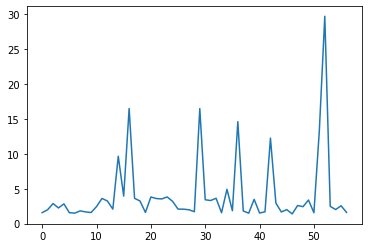

In [17]:
# distances and indexes of k-neaighbors from model outputs
distances, indexes = near.kneighbors(X)# plot mean of k-distances of each observation
plt.plot(distances.mean(axis =1))

pji
5020123    29.661471
620543     16.465731
810451     16.452237
1010403    14.590857
4620256    13.353342
1110525    12.229670
610625      9.641505
dtype: float64

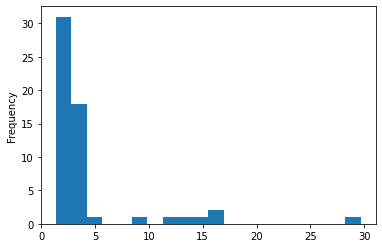

In [19]:
proximity = pd.Series(distances.mean(axis =1))
proximity.index = final_df.index
proximity.plot.hist(bins=20)

threshold = 5
proximity = proximity.sort_values(ascending=False)
proximity = proximity[proximity > threshold]
proximity

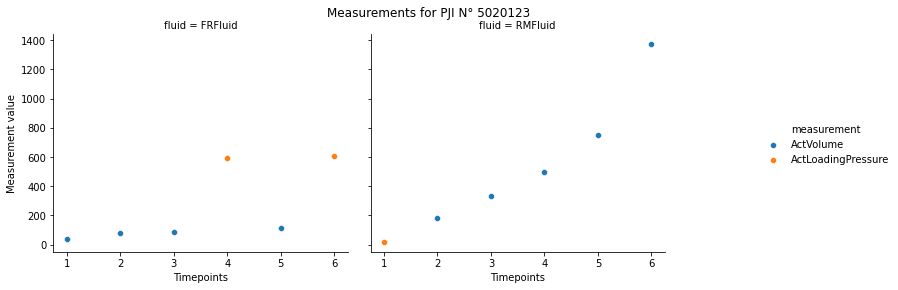

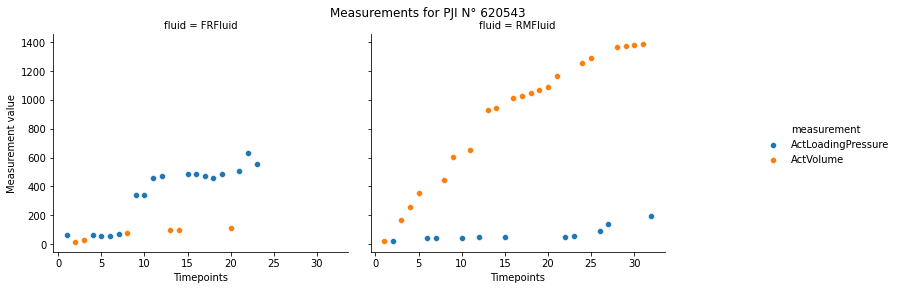

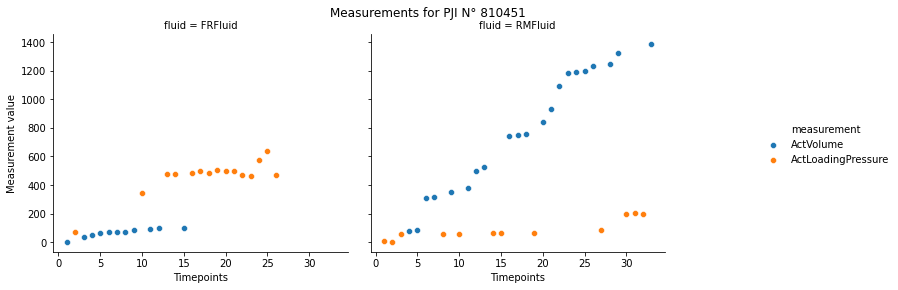

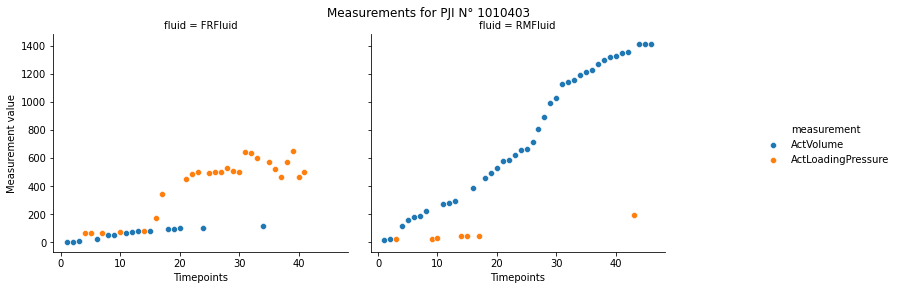

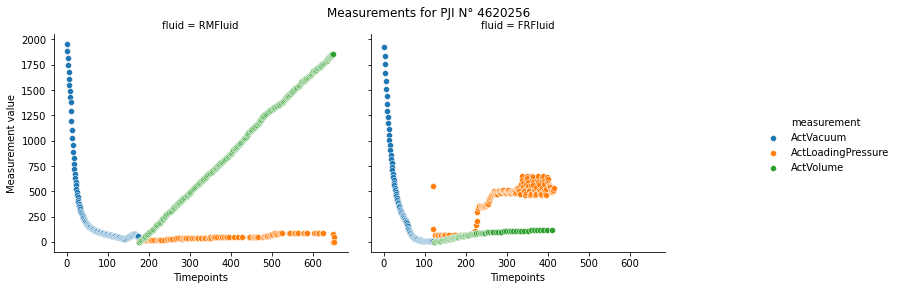

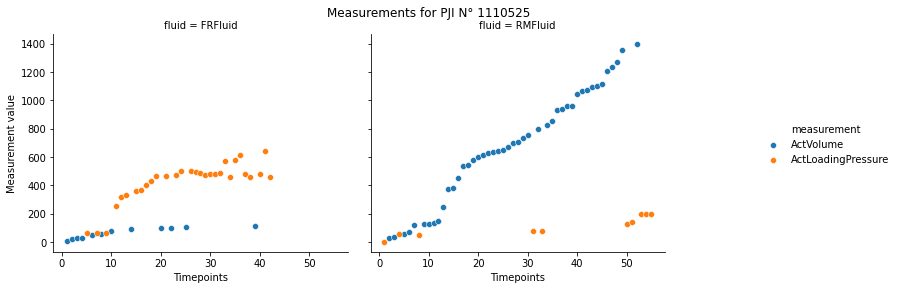

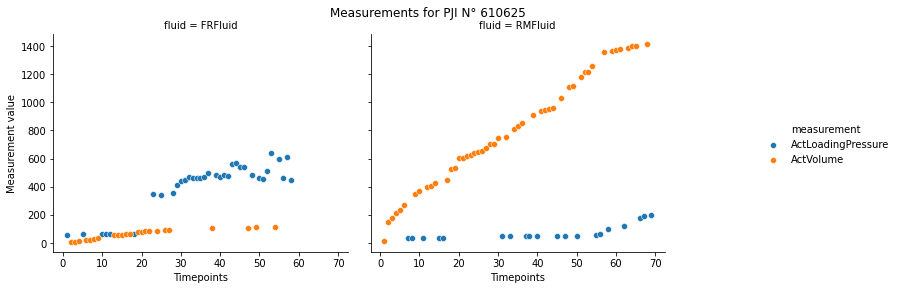

In [20]:
for pji in proximity.index:
    plot_all_fluid(df, pji)

In [68]:
test = pd.read_csv('../data/inference_df_LHA.csv')

test = test.dropna()
test

,Unnamed: 0,siteCode,objectUAI,machine,fluid,measurement,step,sourceTimestamp,pji,dataValue,body_type,driving_side,gearbox_type,hybrid_level,engine_type
0,2,FRLHA,A000003FY5,FillingStation_1,RMFluid,ActVolume,StepLoading,2021-01-28 10:50:38.687000+00:00,4730232.0,823.0,F82,DG,BVM6,NOT_HYBRID,M9R
1,3,FRLHA,A000003FY5,FillingStation_1,FRFluid,ActLoadingPressure,StepLoading,2021-01-28 10:50:51.906000+00:00,4730232.0,610.0,F82,DG,BVM6,NOT_HYBRID,M9R
2,5,FRLHA,A000003FY5,FillingStation_1,FRFluid,ActVolume,StepLoading,2021-01-28 11:04:23.796000+00:00,5230145.0,31.0,F82,DG,BVM6,NOT_HYBRID,M9R
3,11,FRLHA,A000003FY5,FillingStation_1,RMFluid,ActVolume,StepLoading,2021-01-28 11:04:29.703000+00:00,5230145.0,309.0,F82,DG,BVM6,NOT_HYBRID,M9R
4,24,FRLHA,A000003FY5,FillingStation_1,RMFluid,ActVolume,StepLoading,2021-01-28 10:50:40.796000+00:00,4730232.0,920.0,F82,DG,BVM6,NOT_HYBRID,M9R
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60281,110428,FRLHA,A000003FY5,FillingStation_1,FRFluid,ActVacuum,StepVacuumControl,2021-02-01 15:18:46.968000+00:00,610521.0,4.0,F82,DG,BVM6,NOT_HYBRID,M9R
60282,110430,FRLHA,A000003FY5,FillingStation_1,RMFluid,ActVacuum,StepVacuumControl,2021-02-01 04:59:40.046000+00:00,520368.0,42.0,F82,DG,BVM6,NOT_HYBRID,M9R
60283,110431,FRLHA,A000003FY5,FillingStation_1,RMFluid,ActVacuum,StepVacuumControl,2021-02-01 16:07:25.140000+00:00,610490.0,61.0,F82,DG,BVM6,NOT_HYBRID,M9R
60284,110434,FRLHA,A000003FY5,FillingStation_1,FRFluid,ActVacuum,StepVacuumControl,2021-02-01 19:04:24.843000+00:00,610496.0,7.0,F82,DG,BVM6,NOT_HYBRID,M9R


In [117]:
df = test
# conversion of string to datetime
time = pd.to_datetime(df.sourceTimestamp, infer_datetime_format=True)
df['time'] = time
df.sort_values('time', inplace=True)

# add time-delta feature order by pji > fluid > measurement
most_common_df = df.sort_values(['fluid', 'measurement', 'time'])
delta = most_common_df.groupby(['pji', 'fluid', 'measurement'])['time'].diff()
delta = delta.fillna(pd.Timedelta(seconds=0))
delta = delta / np.timedelta64(1, 's')
most_common_df['delta'] = delta.values
most_common_df

,Unnamed: 0,siteCode,objectUAI,machine,fluid,measurement,step,sourceTimestamp,pji,dataValue,body_type,driving_side,gearbox_type,hybrid_level,engine_type,time,delta
1261,8336,FRLHA,A000003FY5,FillingStation_1,FRFluid,ActLoadingPressure,StepLoading,2021-01-28 10:50:18.296000+00:00,4730232.0,540.0,F82,DG,BVM6,NOT_HYBRID,M9R,2021-01-28 10:50:18.296000+00:00,0.000
737,3557,FRLHA,A000003FY5,FillingStation_1,FRFluid,ActLoadingPressure,StepLoading,2021-01-28 10:50:18.687000+00:00,4730232.0,42.0,F82,DG,BVM6,NOT_HYBRID,M9R,2021-01-28 10:50:18.687000+00:00,0.391
865,4446,FRLHA,A000003FY5,FillingStation_1,FRFluid,ActLoadingPressure,StepLoading,2021-01-28 10:50:18.906000+00:00,4730232.0,60.0,F82,DG,BVM6,NOT_HYBRID,M9R,2021-01-28 10:50:18.906000+00:00,0.219
784,3877,FRLHA,A000003FY5,FillingStation_1,FRFluid,ActLoadingPressure,StepLoading,2021-01-28 10:50:19.093000+00:00,4730232.0,61.0,F82,DG,BVM6,NOT_HYBRID,M9R,2021-01-28 10:50:19.093000+00:00,0.187
494,2199,FRLHA,A000003FY5,FillingStation_1,FRFluid,ActLoadingPressure,StepLoading,2021-01-28 10:50:19.406000+00:00,4730232.0,62.0,F82,DG,BVM6,NOT_HYBRID,M9R,2021-01-28 10:50:19.406000+00:00,0.313
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29703,69715,FRLHA,A000003FY5,FillingStation_1,RMFluid,ActVolume,StepLoading,2021-02-01 20:07:10.343000+00:00,610468.0,1416.0,F82,DG,BVM6,NOT_HYBRID,M9R,2021-02-01 20:07:10.343000+00:00,0.593
39300,82340,FRLHA,A000003FY5,FillingStation_1,RMFluid,ActVolume,StepLoading,2021-02-01 20:07:11.234000+00:00,610468.0,1417.0,F82,DG,BVM6,NOT_HYBRID,M9R,2021-02-01 20:07:11.234000+00:00,0.891
36768,79039,FRLHA,A000003FY5,FillingStation_1,RMFluid,ActVolume,StepLoading,2021-02-01 20:07:12.343000+00:00,610468.0,1418.0,F82,DG,BVM6,NOT_HYBRID,M9R,2021-02-01 20:07:12.343000+00:00,1.109
32875,73900,FRLHA,A000003FY5,FillingStation_1,RMFluid,ActVolume,StepLoading,2021-02-01 20:07:14.140000+00:00,610468.0,1419.0,F82,DG,BVM6,NOT_HYBRID,M9R,2021-02-01 20:07:14.140000+00:00,1.797


In [12]:
most_common_df = most_common_df[most_common_df['measurement'] != 'ActVacuum']
bad_pji = get_pji_with_misssing_fluids_measure(most_common_df, 2, 2)
# Global organisation of the data
# remove pji without 3 fluids and 3 measurements
#bad_pji = get_pji_with_misssing_fluids_measure(most_common_df)
most_common_df = most_common_df[~most_common_df.pji.isin(bad_pji)]


# Observations are PJI
# columns are the differents features regrouped by fluids and measurements
# important features
# Average dataValue in tail(10)
mean_tail_value = most_common_df.groupby(['pji', 'fluid', 'measurement']).tail(4)
mean_tail_value = mean_tail_value.groupby(['pji', 'fluid', 'measurement'])[['dataValue']].mean()
#mean_tail_value

summary = most_common_df\
.groupby(['pji', 'fluid', 'measurement'])['dataValue']\
.describe(percentiles=[0.1, 0.2, 0.8, 0.9]
)
summary = summary.drop(['count', 'std'], axis=1)

# Number of points in each group + average time delta
timing = most_common_df.groupby(['pji', 'fluid', 'measurement']).agg({'delta':['count', 'mean', 'max']})
#timing

# Slope values (min max or q10, q90)
temp = most_common_df.copy()
temp = temp.sort_values(['fluid', 'measurement', 'time'])
slope = temp.groupby(['pji', 'fluid', 'measurement'])['dataValue'].diff()
temp = most_common_df.copy()
temp['slope'] = slope
temp = temp.groupby(['pji', 'fluid', 'measurement']).agg({'slope':["mean", "max"]})

#temp

global_merged = pd.concat([mean_tail_value, timing, temp, summary], axis=1, join='inner')
column_list = global_merged.columns
final_df = global_merged.pivot_table(values=column_list, 
                   index = ['pji'],
                   columns=['fluid', 'measurement'], sort=False )

final_df

dataValue            ...                max          
fluid                  FRFluid            ...            RMFluid          
measurement ActLoadingPressure ActVolume  ... ActLoadingPressure ActVolume
pji                                       ...                             
130567                  528.50    116.50  ...              200.0    1422.0
220378                  537.25    117.50  ...              200.0    1427.0
310143                  511.50    116.50  ...              202.0    1390.0
310167                  520.50    117.50  ...              200.0    1418.0
310586                  533.00    116.50  ...              200.0    1421.0
320115                  540.75    116.50  ...              201.0    1421.0
320294                  530.00    116.50  ...              200.0    1422.0
330063                  539.00    116.50  ...              200.0    1399.0
330549                  539.25    116.50  ...              200.0    1419.0
340237                  538.50    116.50  ...              200.0    1420.0
340316                  538.00    117.50  ...              200.0    1426.0
350038                  537.50    116.50  ...              202.0    1476.0
350041                  525.00    116.50  ...              201.0    1477.0
350156                  539.50    117.50  ...              201.0    1423.0
610625                  530.00    109.75  ...              198.0    1415.0
620372                  489.75    115.50  ...              200.0    1398.0
620543                  544.75     96.75  ...              197.0    1389.0
630207                  473.75    115.50  ...              200.0    1400.0
640116                  503.00    114.75  ...              199.0    1425.0
640364                  528.50    116.50  ...              200.0    1398.0
640367                  525.25    114.50  ...              199.0    1419.0
650149                  480.00    113.75  ...              199.0    1399.0
650183                  502.50    117.50  ...              201.0    1410.0
730150                  519.75    112.00  ...              200.0    1418.0
740007                  501.75    115.50  ...              200.0    1419.0
740155                  502.00    117.50  ...              200.0    1419.0
740156                  526.75    117.50  ...              200.0    1419.0
740170                  534.50    117.50  ...              200.0    1396.0
810189                  538.50    115.50  ...              200.0    1401.0
810451                  536.50     93.25  ...              201.0    1388.0
810452                  527.75    117.50  ...              202.0    1389.0
810589                  477.50    114.50  ...              199.0    1417.0
810778                  513.25    114.00  ...              201.0    1399.0
910105                  520.25    117.50  ...              200.0    1420.0
911115                  518.25    115.25  ...              200.0    1421.0
940005                  537.25    116.50  ...              200.0    1419.0
1010403                 546.25    100.25  ...              196.0    1413.0
1010501                 527.50    117.50  ...              199.0    1397.0
1010502                 528.50    117.50  ...              207.0    1418.0
1010569                 543.00    115.50  ...              202.0    1415.0
1030229                 531.75    116.50  ...              200.0    1400.0
1030230                 516.00    117.50  ...              199.0    1420.0
1110525                 510.00    104.00  ...              198.0    1399.0
1110536                 510.75    117.50  ...              201.0    1408.0
1140011                 510.50    116.50  ...              199.0    1393.0
1210159                 505.25    116.50  ...              200.0    1421.0
1210184                 533.25    116.50  ...              199.0    1419.0
1210190                 544.50    116.50  ...              202.0    1421.0
1210209                 524.25    116.50  ...              199.0    1399.0
1610123                 509.25    117.50  ... 

In [13]:
X_test = pipe.transform(final_df)
distances, indexes = near.kneighbors(X_test)

NameError: name 'pipe' is not defined

pji
430051.0    12.734641
410339.0    12.528083
dtype: float64

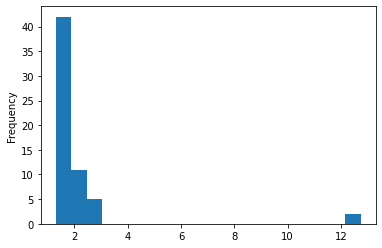

In [84]:
proximity = pd.Series(distances.mean(axis =1))
proximity.index = final_df.index
proximity.plot.hist(bins=20)

threshold = 5
proximity = proximity.sort_values(ascending=False)
proximity = proximity[proximity > threshold]
proximity

In [85]:
bad_pji

[420147.0]

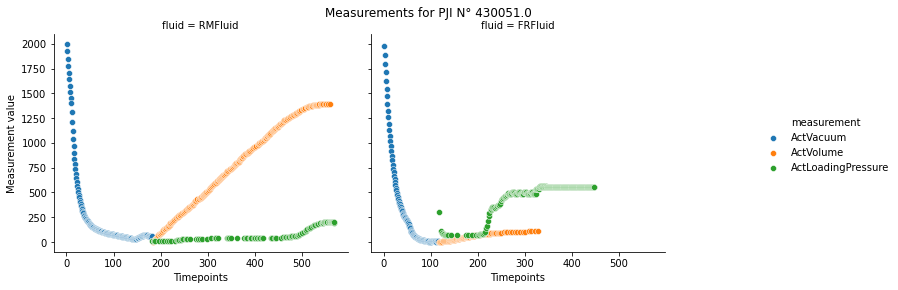

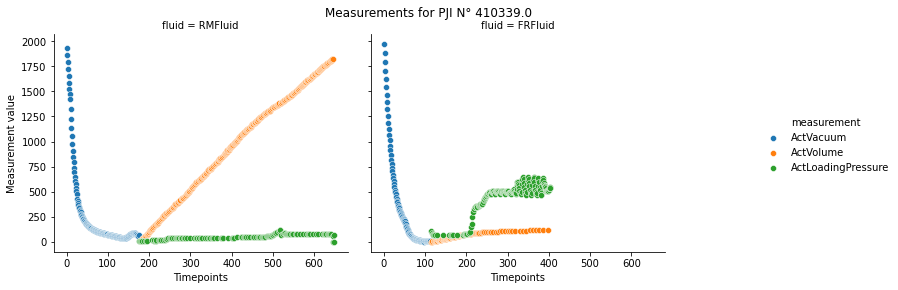

In [86]:
for pji in proximity.index:
    plot_all_fluid(df, pji)

In [80]:
len(df.pji.unique())

61

# Case of Junary 29th

Jump from 28/01 to 01/02

In [107]:
case = df[df.time.dt.month == 2]

In [ ]:
for pji in case.pji.unique()[:5]:
    plot_all_fluid(df, pji)

In [123]:
case = df.groupby('pji')['time'].mean().reset_index().tail()['pji']

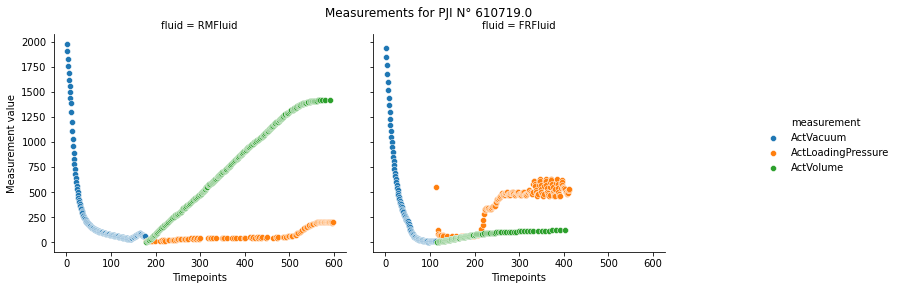

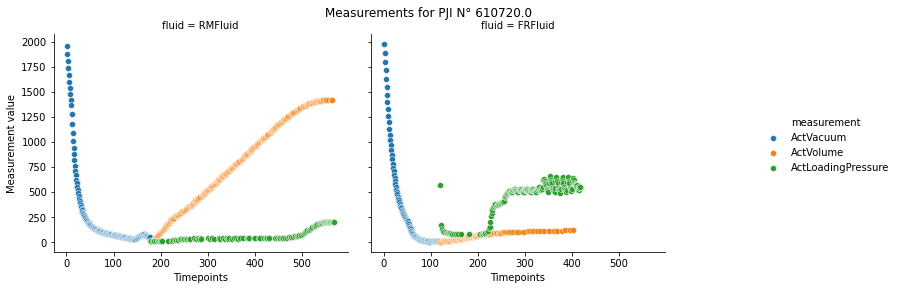

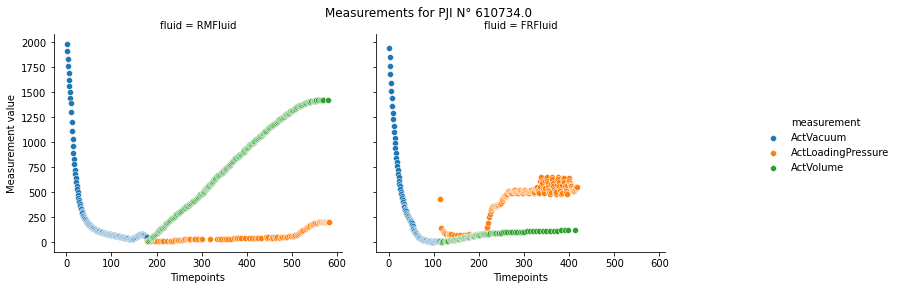

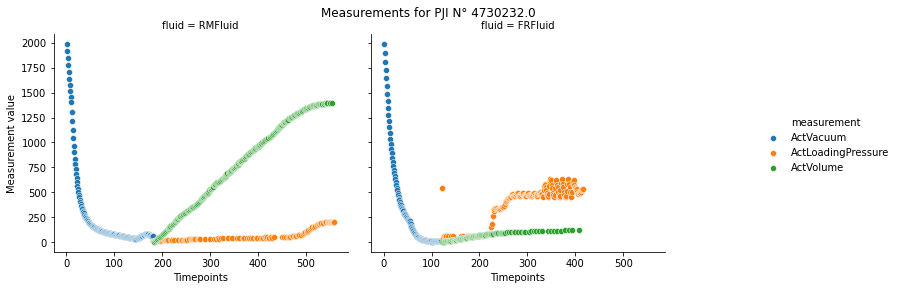

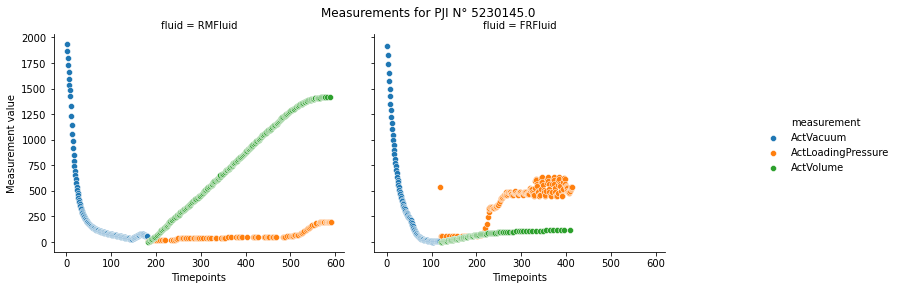

In [124]:
for pji in case:
    plot_all_fluid(df, pji)

In [132]:
temp = df.groupby(['pji', 'fluid'])['time'].min().reset_index()
temp = pd.pivot(temp, index=['pji'],values=['time'], columns=['fluid'])

In [134]:
temp.columns = ['FR', 'RM']

pji
340192.0     True
340207.0     True
340369.0     True
340371.0     True
350077.0     True
             ... 
610719.0     True
610720.0     True
610734.0     True
4730232.0    True
5230145.0    True
Length: 61, dtype: bool